# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)

### <a class="anchor">Imports and Bring in Data</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

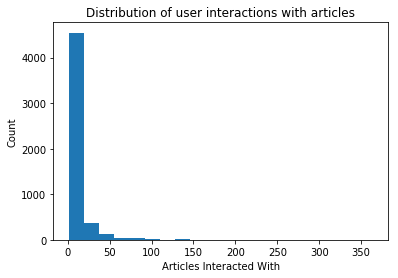

In [3]:
dist = df.groupby('email')['article_id'].count().sort_values().reset_index(name='count')
plt.hist(dist['count'], bins=20)
plt.xlabel('Articles Interacted With')
plt.ylabel('Count')
plt.title('Distribution of user interactions with articles')
plt.show()

In [4]:
dist.iloc[-3:]

,email,count
5145,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
5146,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
5147,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364


In [5]:
dist.describe()

,count
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


The average user interacts with ~9 articles, while the median user interacts with 3 articles. The largest number of interactions is 364.

In [6]:
# Fill in the median and maximum number of user_article interactions below
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
# should return 10 records (5 pairs of duplicates)
df_content[df_content['article_id'].duplicated(keep=False)].sort_values(by='article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [8]:
df_content.shape

(1056, 5)

In [9]:
# Remove any rows that have the same article_id - only keep the first
# Removed 5 duplicates
df_content = df_content.drop_duplicates(subset='article_id')
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [11]:
print('unique_articles: ', unique_articles)
print('total_articles: ', total_articles)
print('unique_users: ', unique_users)
print('user_article_interactions: ', user_article_interactions)

unique_articles:  714
total_articles:  1051
unique_users:  5148
user_article_interactions:  45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
# count how many times each article_id shows up in df
df['article_id'].value_counts().reset_index(name='count')[:3]

,index,count
0,1429.0,937
1,1330.0,927
2,1431.0,671


In [13]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df['article_id'].value_counts().reset_index(name='count').iloc[0][0])

# The most viewed article in the dataset was viewed how many times?
max_views = df['article_id'].value_counts().reset_index(name='count').iloc[0][1]

In [14]:
print('most_viewed_article_id: ', most_viewed_article_id)
print('max_views: ', max_views)

most_viewed_article_id:  1429.0
max_views:  937.0


In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # count the number of times each article had an interaction, sorted descending
    top_article_ids_df = df['article_id'].value_counts().reset_index(name='count')[:n]
    
    # grab the indices for selecting in the next step
    top_article_ids = list(top_article_ids_df['index'])
        
    # Return the titles in the correct order
    top_article_titles = []
    for id in top_article_ids:
        title = df[df['article_id'] == id]['title'].iloc[0]
        top_article_titles.append(title)
    
    # Return the top article titles from df (not df_content)
    return top_article_titles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article_ids 
    
    '''
    # count the number of times each article had an interaction, sorted descending
    top_article_ids = df['article_id'].value_counts().reset_index(name='count')[:n]
    
    # grab the indices for selecting in the next step
    top_article_ids = list(top_article_ids['index'])
 
    return top_article_ids 

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Create a dataframe with user_ids as rows and article_ids as columns, filling in all NaNs with 0
    # Using .size() is another approach and would then need to replace the 2s with 1s
    # df.groupby(['user_id', 'article_id']).size().unstack().fillna(0)
    # Another approach using pd.pivot_table(df, values='title', index=['user_id'], columns=['article_id'], 
    #         aggfunc='count', fill_value=0), would just need to get the correct aggfunc
    df_with_text = df.groupby(['user_id', 'article_id']).max().unstack().fillna(0)
    
    # Replace the text (all the non-zero cells) with a 1
    user_item = df_with_text.replace(to_replace=r'[^0]', value=1, regex=True)
    
    # convert from multiIndex to normal index
    user_item.columns = user_item.columns.get_level_values(1)
    
    return user_item 

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # user_item starts at 1, rather than 0, so subtract one from my user_id to get it's corresponding iloc value
    user_row = user_item.iloc[user_id - 1]
    
    # compute similarity of each user to the provided user
    similarity = np.dot(user_row, user_item.T)
    
    # sort by similarity
    # argsort returns the indices that would sort an array, with the negative putting them in reverse order
    sorted_indices = np.argsort(-similarity)
    
    # the 0th index should then actually correspond with user_id 1,
    # so I need to add one to all of these values to switch back to user_ids
    sorted_indices += 1
    
    # remove the own user's id, which will be the 0th item in the sorted array
    most_similar_users = list(sorted_indices[1:])
           
    return most_similar_users # return a list of the users in order from most to least similar     

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 3870, 131, 46, 4201, 49]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for id in article_ids:
        title = df[df['article_id'] == float(id)]['title'].iloc[0]
        article_names.append(title)
    
    # Return the article names associated with list of article ids
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # user_item starts at 1, rather than 0, so subtract 1 from user_id to pass to .iloc to get the row
    # associated with the user_id
    user_interacted_test = user_item.iloc[user_id - 1].reset_index(name='interacted')[['article_id', 'interacted']]
    
    # only look at the articles they interacted with
    article_ids = list(user_interacted_test[user_interacted_test.interacted == 1]['article_id'])
    
    # apparently the test wants the ids as strings, so I'll convert them to strings
    article_ids = [str(id) for id in article_ids]
    
    # actually need to grab the title from df rather than df_content because df_content doesn't
    # have all of the article_ids we need to look up in the test
    article_names = list(df[df.article_id.isin([float(id) for id in article_ids])]['title'].unique())
    
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user (article_ids)
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    total_recs = 0
    recs = []
    
    # articles already seen by user_id
    article_ids = get_user_articles(user_id)[0]
    
    # return a list of the users in order from most to least similar
    most_similar_users = find_similar_users(user_id, user_item=user_item)
    
    for user in most_similar_users:
        # need to stop giving recs once total_recs == m
        if total_recs == m:
            break
        # find the article_ids that user has interacted with, then, if main user_id hasn't already seen that
        # article_id, add it to recs
        # articles seen by user. 0th item is the article_ids
        article_ids_user = get_user_articles(user)[0]

        for article_id_user in article_ids_user:
            if article_id_user not in article_ids:
                recs.append(article_id_user)
                total_recs += 1
            if total_recs == m:
                break
        
    return recs # return your recommendations for this user_id    

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [26]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # user_item starts at 1, rather than 0, so subtract one from my user_id to get it's corresponding iloc value
    # pandas Series of shape (714,) that has all the article_ids with a 0 or 1 depending on if they interacted w/
    # that article
    user_row = user_item.iloc[user_id - 1]

    # compute similarity of each user to the provided user
    # these are the similarities I need for the dataframe
    similarity = np.dot(user_row, user_item.T)

    # sort by similarity
    # argsort returns the indices that would sort an array, with the negative putting them in reverse order
    sorted_indices = np.argsort(-similarity)
    
    # the 0th index should then actually correspond with user_id 1,
    # so I need to add one to all of these values to switch back to user_ids
    sorted_indices += 1

    # sort the similarity scores
    sorted_test = np.sort(similarity)[::-1]

    # zip them together and store in a Dataframe
    list_of_tuples = list(zip(sorted_indices, sorted_test))
    neighbors_df = pd.DataFrame(list_of_tuples, columns = ['neighbor_id', 'similarity'])

    # remove the user's similarity with themself by dropping the first record
    neighbors_df = neighbors_df.drop(neighbors_df.index[0])
    
    # user_id and how many articles they've interacted with
    user_interactions = df.groupby('user_id')['article_id'].count()\
        .sort_values(ascending=False).reset_index(name='count')
    
    # add num_interactions column
    neighbors_df = pd.merge(neighbors_df, user_interactions, how='left', \
                 left_on='neighbor_id', right_on='user_id').drop('user_id', axis=1)
    
    # then sort dataframe desc by similarity and then by number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'count'], ascending=[False, False])
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the most total interactions before choosing those with fewer total interactions. 
   
    '''    
    total_recs = 0
    recs = []
    
    # articles already seen by user_id
    article_ids = get_user_articles(user_id)[0]
    
    # return a list of the users in order from most to least similar
    # most_similar_users = find_similar_users(user_id, user_item=user_item)
    # df has 3 columns in it: neighbor_id, similarity, num_interactions 
    # difference is these user_ids have been sorted by similarity score and number of interactions
    most_similar_users_df = get_top_sorted_users(user_id)
    most_similar_users = list(most_similar_users_df['neighbor_id'])
    
    #while total_recs < m:
    for user in most_similar_users:
        if total_recs == m:
            break
        # find the article_ids that user has interacted with, then, if main user_id hasn't already seen that
        # article_id, add it to recs
        # articles seen by user. 0th item is the article_ids
        article_ids_user = get_user_articles(user)[0]

        # sort article_ids that the user has seen based on their number of interactions
        
        # these are all of the article_ids sorted by number of interactions
        article_interactions = df['article_id'].value_counts().reset_index(name='count')
        
        # rename 'index' column back to 'article_id'
        article_interactions.rename(columns={'index':'article_id'}, inplace=True)
        
        # filter down article_interactions to the articles the given user has interacted with
        articles_seen_by_user_sorted_df = article_interactions[article_interactions['article_id']\
                                                               .isin(article_ids_user)]
        
        # grab just the article_ids from the dataframe
        article_ids_user = list(articles_seen_by_user_sorted_df['article_id'])
        
        for article_id_user in article_ids_user:
            if article_id_user not in article_ids:
                recs.append(article_id_user)
                total_recs += 1
            if total_recs == m:
                break
    
    # translate the ids to titles
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
# Find the user that is most similar to user 1
most_similar_users_df = get_top_sorted_users(1)
most_similar_users = list(most_similar_users_df['neighbor_id'])
most_similar_users[0]

3933

In [30]:
# Find the 10th most similar user to user 131
most_similar_users_df = get_top_sorted_users(131)
most_similar_users = list(most_similar_users_df['neighbor_id'])
most_similar_users[9]

242

In [31]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [32]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

This is the cold start problem. I would only be able to use the rank-based methods to recommend the most popular articles because collaborative filtering uses a user-item matrix to compute similarity scores. Since the user is new, they wouldn't be in that matrix, and we wouldn't be able to compute a useful similarity score.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to them.

# 10 most popular articles
new_user_recs = get_top_article_ids(10)

# Convert ids to strings to match the test in the next cell
new_user_recs = [str(id) for id in new_user_recs]

In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [35]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [37]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

- In this case, we have a user-item matrix with no missing values, so we can use SVD. We are also dealing with interactions (1/0) rather than ratings.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

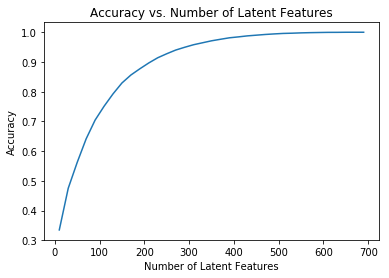

In [38]:
def plot_latent_features(u, s, vt, user_item_matrix, df):
    '''
    Plot the accuracy vs. number of latent features
    '''
    num_latent_feats = np.arange(10,700+10,20)
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_matrix, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)


    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    
plot_latent_features(u, s, vt, user_item_matrix, df)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [39]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    train_idx - all of the train user ids
    test_idx - all of the test user ids
    train_arts - all of the train article ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = list(df_train['user_id'].unique())
    test_idx = list(df_test['user_id'].unique())
    
    train_arts = list(df_train['article_id'].unique())
    test_arts = list(df_test['article_id'].unique())
    
    return user_item_train, user_item_test, train_idx, test_idx, train_arts, test_arts

user_item_train, user_item_test, train_idx, test_idx, \
    train_arts, test_arts = create_test_and_train_user_item(df_train, df_test)

In [40]:
# How many users can we make predictions for in the test set?
# We need to have seen the user in the training set in order to avoid the cold start problem
preds_for_test_users = len(set(train_idx) & set(test_idx))
preds_for_test_users

20

In [41]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(test_idx) - preds_for_test_users

662

In [42]:
# How many articles can we make predictions for in the test set?
# All of the test articles also appear in the training data
len(set(train_arts) & set(test_arts))

574

In [43]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [44]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [45]:
# after fitting SVD on the user_item_train matrix, find out which rows match the test set from u,s,v
# create a boolean mask for the user_ids and article_ids that appear in train and test sets
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)

# update the decomposition matrices so they only contain the appropriate columns
# u_test shape: (20, 4487)
u_test = u_train[row_idxs, :]

# vt_test shape: (714, 574)
vt_test = vt_train[:, col_idxs]

# for later subsetting of user_item_test down to the 20 rows of user_ids that exist in the training and test sets
user_ids_in_both_train_and_test = list(set(train_idx) & set(test_idx))

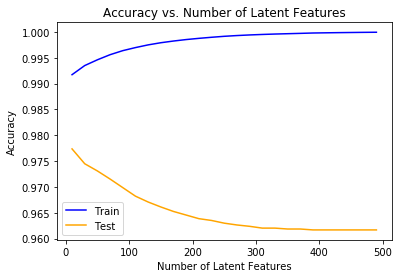

In [46]:
# plot accuracy vs. number of latent features
num_latent_feats = np.arange(10,500+10,20)
sum_errs_train = []
sum_errs_test = []
  
for k in num_latent_feats:
    # restructure with k latent features using the new SVD matrices ending in _train
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]

    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    # subset user_item_test to the 20 rows for user_ids in both train and test sets
    diffs_test = np.subtract(user_item_test.loc[user_ids_in_both_train_and_test], user_item_test_preds)

    # Keep track of errors for each number of latent features
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test))) 
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

# create denominators for each plot
train_total_entries = user_item_train_preds.shape[0] * user_item_train_preds.shape[1]
test_total_entries = user_item_test_preds.shape[0] * user_item_test_preds.shape[1]

# plot train errors
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/train_total_entries, color='blue', label='Train');

# plot test errors
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/test_total_entries, color='orange', label='Test');

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

- Based on plotting accuracy vs. number of latent features for my predictions, we get high accuracy (96% or more), which we would expect because the majority of the cells are zeros. There were only 20 individuals who were in both the training and testing datasets, so there isn't a lot of data to test how well predictions via collaborative filtering with SVD are matching up with actual values.

- To determine if the recommendations made above are an improvement to how users currently find articles, we would want to conduct an A/B test.